In [110]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
import shap

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import plotly.graph_objects as go
import plotly.express as px


In [111]:
import sys

sys.path.append("../../")
from src.model_data_prep import create_outbreak_summary

# Using the linked dataset in a baseline model for predicting disease outbreak periods

This notebook demonstrates the use of the linked dataset in creating a baseline model for predicting disease outbreaks.
We will create a model that covers the following:

| Specifications     |                |
|--------------------|----------------|
| Location           | Zamboanga City |
| Disease to predict | Dengue         |
| Years covered      | 2014-2020      |
| Model              | Random Forest  |

We include the following as environmental factors:

| Factor            | Variables                                                                              |
|-------------------|----------------------------------------------------------------------------------------|
| Climate           | temperature, humidity, rainfall, solar radiation, wind speed, vegetation, air quality  |
| Demographics      | population, population density                                                         |
| Facilities        | clinics, hospitals, sanitation, water source,                                          |
| Economic activity | nightlights radiance                                                                   |


For this model, we will use 6 years and 3 months (Jan 2014-Mar 2019) as training data and will find out if we can sufficiently predict disease outbreaks for the next 1 year and 8 months (Apr 2019- Dec 2020).



In [112]:
PROCESSED_DIR = Path("../../data/03-processed/")
# LINKED_DATA = PROCESSED_DIR / "linked_df_city_weekly_dengue.csv"
LINKED_DATA = (
    PROCESSED_DIR / "linked_training_data/linked_df_pidsr_city_weekly_dengue.csv"
)

## Load the labeled linked dataset

Generate the linked dataset using this [notebook](colab) and download locally. The linked dataset should be in a city-weekly format wherein each row refers to a week and contains the number of cases, outbreak label, and other external features (climate, socioeconomic). 

In [113]:
linked_data = pd.read_csv(LINKED_DATA)
linked_data.head()

,Source,year,Month,Week,Date,Region,PSGC_Region,Municipality,ADM3_PCODE,ICD,...,google_bldgs_density_mean,google_bldgs_pct_built_up_area_sum,google_bldgs_pct_built_up_area_mean,travel_time,hospital_pop_reached_total,hospital_pct_population_reached,healthcenter_pop_reached_total,healthcenter_pct_population_reached,rhu_pop_reached_total,rhu_pct_population_reached
0,PIDSR-DOH,2008.0,1.0,1,2008-01-07,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,...,0.001116,908.037478,8.99047,5,124434.91,14.46,456862.05,53.09,301674.11,35.06
1,PIDSR-DOH,2008.0,1.0,2,2008-01-07,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,...,0.001116,908.037478,8.99047,5,124434.91,14.46,456862.05,53.09,301674.11,35.06
2,PIDSR-DOH,2008.0,1.0,3,2008-01-14,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,...,0.001116,908.037478,8.99047,5,124434.91,14.46,456862.05,53.09,301674.11,35.06
3,PIDSR-DOH,2008.0,1.0,4,2008-01-21,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,...,0.001116,908.037478,8.99047,5,124434.91,14.46,456862.05,53.09,301674.11,35.06
4,PIDSR-DOH,2008.0,1.0,5,2008-01-28,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,...,0.001116,908.037478,8.99047,5,124434.91,14.46,456862.05,53.09,301674.11,35.06


Sort the dataframe by Date and place it at the left-most column.

In [114]:
linked_data["Date"] = pd.to_datetime(linked_data["Date"])
linked_data = linked_data.sort_values(by=["Date"])
linked_data = linked_data.drop(columns=["start_of_week"])
linked_data.insert(0, "Date", linked_data.pop("Date"))

## Filter, select, and create features

### 1. Filter to year with existing OSM and population data

OSM-related features are only available from year 2014 onwards and the population features are only availble until year 2020. 

In [115]:
linked_data = linked_data[(linked_data["year"] >= 2014) & (linked_data["year"] <= 2020)]

In [116]:
linked_data.shape

(364, 254)

In [117]:
print(linked_data.columns.tolist())

['Date', 'Source', 'year', 'Month', 'Week', 'Region', 'PSGC_Region', 'Municipality', 'ADM3_PCODE', 'ICD', 'Disease', 'Cases', 'Claims', 'Deaths', 'Case_Type', 'Date_Type', 'outbreak', 'outbreak_group', 'CO_AVG_mean', 'CO_MIN_mean', 'CO_MAX_mean', 'CO_STD_mean', 'WEIGHTED_AVG_CO_mean', 'HI_AVG_mean', 'HI_MIN_mean', 'HI_MAX_mean', 'HI_STD_mean', 'WEIGHTED_AVG_HI_mean', 'NDVI_AVG_mean', 'NDVI_MIN_mean', 'NDVI_MAX_mean', 'NDVI_STD_mean', 'WEIGHTED_AVG_NDVI_mean', 'NO2_AVG_mean', 'NO2_MIN_mean', 'NO2_MAX_mean', 'NO2_STD_mean', 'WEIGHTED_AVG_NO2_mean', 'O3_AVG_mean', 'O3_MIN_mean', 'O3_MAX_mean', 'O3_STD_mean', 'WEIGHTED_AVG_O3_mean', 'PM10_AVG_mean', 'PM10_MIN_mean', 'PM10_MAX_mean', 'PM10_STD_mean', 'WEIGHTED_AVG_PM10_mean', 'PM25_AVG_mean', 'PM25_MIN_mean', 'PM25_MAX_mean', 'PM25_STD_mean', 'WEIGHTED_AVG_PM25_mean', 'PNP_AVG_mean', 'PNP_MIN_mean', 'PNP_MAX_mean', 'PNP_STD_mean', 'WEIGHTED_AVG_PNP_mean', 'PR_AVG_mean', 'PR_MIN_mean', 'PR_MAX_mean', 'PR_STD_mean', 'WEIGHTED_AVG_PR_mean', 'R

### 2. Inspect missing data

In [118]:
print(linked_data.columns[linked_data.isnull().any()].tolist())

['Claims', 'Deaths', 'PNP_AVG_mean', 'PNP_MIN_mean', 'PNP_MAX_mean', 'PNP_STD_mean', 'WEIGHTED_AVG_PNP_mean', 'SPI3_AVG_mean', 'SPI3_MIN_mean', 'SPI3_MAX_mean', 'SPI3_STD_mean', 'WEIGHTED_AVG_SPI3_mean', 'SPI6_AVG_mean', 'SPI6_MIN_mean', 'SPI6_MAX_mean', 'SPI6_STD_mean', 'WEIGHTED_AVG_SPI6_mean']


### 3. Remove columns that could cause the model confusion

In [119]:
# remove ookla for now
filtered_linked_df = linked_data.drop(
    columns=[
        "Source",
        "year",
        "Month",
        "Week",
        "Region",
        "PSGC_Region",
        "Municipality",
        "ICD",
        "Disease",
        "Claims",
        "Deaths",
        "Case_Type",
        "Date_Type",
        "outbreak_group",
        # remove climate features with nulls
        "PNP_AVG_mean",
        "PNP_MIN_mean",
        "PNP_MAX_mean",
        "PNP_STD_mean",
        "WEIGHTED_AVG_PNP_mean",
        "SPI3_AVG_mean",
        "SPI3_MIN_mean",
        "SPI3_MAX_mean",
        "SPI3_STD_mean",
        "WEIGHTED_AVG_SPI3_mean",
        "SPI6_AVG_mean",
        "SPI6_MIN_mean",
        "SPI6_MAX_mean",
        "SPI6_STD_mean",
        "WEIGHTED_AVG_SPI6_mean",
        # remove static columns
        # health facility POIs that are static
        "doh_pois_count_sum",
        "doh_pois_count_mean",
        "doh_brgy_health_station_count_sum",
        "doh_brgy_health_station_count_mean",
        "doh_rural_health_unit_count_sum",
        "doh_rural_health_unit_count_mean",
        "doh_hospital_count_sum",
        "doh_hospital_count_mean",
        "doh_birthing_home_lying_in_clinic_count_sum",
        "doh_birthing_home_lying_in_clinic_count_mean",
        "doh_infirmary_count_sum",
        "doh_infirmary_count_mean",
        "doh_drug_abuse_treatment_rehabilitation_center_count_sum",
        "doh_drug_abuse_treatment_rehabilitation_center_count_mean",
        "doh_social_hygiene_clinic_count_sum",
        "doh_social_hygiene_clinic_count_mean",
        "doh_medical_clinic_count_sum",
        "doh_medical_clinic_count_mean",
        "weighted_avg_doh_brgy_health_station_nearest_mean",
        "weighted_avg_doh_rural_health_unit_nearest_mean",
        "weighted_avg_doh_hospital_nearest_mean",
        "weighted_avg_doh_birthing_home_lying_in_clinic_nearest_mean",
        "weighted_avg_doh_infirmary_nearest_mean",
        "weighted_avg_doh_drug_abuse_treatment_rehabilitation_center_nearest_mean",
        "weighted_avg_doh_social_hygiene_clinic_nearest_mean",
        "weighted_avg_doh_medical_clinic_nearest_mean",
        # static flood hazard features
        "pct_area_flood_hazard_100yr_low_mean",
        "pct_area_flood_hazard_100yr_med_mean",
        "pct_area_flood_hazard_100yr_high_mean",
        "pct_area_flood_hazard_25yr_low_mean",
        "pct_area_flood_hazard_25yr_med_mean",
        "pct_area_flood_hazard_25yr_high_mean",
        "pct_area_flood_hazard_5yr_low_mean",
        "pct_area_flood_hazard_5yr_med_mean",
        "pct_area_flood_hazard_5yr_high_mean",
        "pct_area_landslide_hazard_low_mean",
        "pct_area_landslide_hazard_med_mean",
        "pct_area_landslide_hazard_high_mean",
        # static landcover features
        "pct_area_bare_sparse_vegetation_mean",
        "pct_area_builtup_mean",
        "pct_area_cropland_mean",
        "pct_area_grassland_mean",
        "pct_area_herbaceous_wetland_mean",
        "pct_area_mangroves_mean",
        "pct_area_permanent_water_bodies_mean",
        "pct_area_shrubland_mean",
        "pct_area_tree_cover_mean",
        # static infrastructure features
        "google_bldgs_count_sum",
        "google_bldgs_count_mean",
        "google_bldgs_area_total_sum",
        "google_bldgs_area_total_mean",
        "google_bldgs_area_mean_sum",
        "google_bldgs_area_mean_mean",
        "google_bldgs_count_lt100_sqm_sum",
        "google_bldgs_count_lt100_sqm_mean",
        "google_bldgs_count_100_200_sqm_sum",
        "google_bldgs_count_100_200_sqm_mean",
        "google_bldgs_count_gt_200_sqm_sum",
        "google_bldgs_count_gt_200_sqm_mean",
        "google_bldgs_density_sum",
        "google_bldgs_density_mean",
        "google_bldgs_pct_built_up_area_sum",
        "google_bldgs_pct_built_up_area_mean",
        # static isochrone features
        "travel_time",
        "hospital_pop_reached_total",
        "hospital_pct_population_reached",
        "healthcenter_pop_reached_total",
        "healthcenter_pct_population_reached",
        "rhu_pop_reached_total",
        "rhu_pct_population_reached",
    ]
)

### 4. Handle rows with null values

- Replace null values for `Nightlight` features with 0

In [120]:
ntl_features = [
    "avg_rad_min_mean",
    "avg_rad_max_mean",
    "avg_rad_mean_mean",
    "avg_rad_std_mean",
    "avg_rad_median_mean",
]
filtered_linked_df[ntl_features] = filtered_linked_df[ntl_features].fillna(0)

### 5. Create lagged features for `Cases`

Adding previous week's cases as features may help enhance the model's capability in predicting future cases.

In [121]:
# Group by barangay and return the date of the previous number of cases
filtered_linked_df = filtered_linked_df.assign(
    prev_1_wk_numcases=filtered_linked_df["Cases"].shift(
        1, fill_value=0
    ),  # cases a week before
    prev_2_wk_numcases=filtered_linked_df["Cases"].shift(
        2, fill_value=0
    ),  # cases 2 weeks before
    prev_3_wk_numcases=filtered_linked_df["Cases"].shift(
        3, fill_value=0
    ),  # cases 3 weeks before
    prev_1_mo_numcases=filtered_linked_df["Cases"].shift(
        4, fill_value=0
    ),  # cases 1 month before
)
filtered_linked_df.shape

(364, 159)

In [122]:
# print out final columns
print(list(filtered_linked_df.columns))

['Date', 'ADM3_PCODE', 'Cases', 'outbreak', 'CO_AVG_mean', 'CO_MIN_mean', 'CO_MAX_mean', 'CO_STD_mean', 'WEIGHTED_AVG_CO_mean', 'HI_AVG_mean', 'HI_MIN_mean', 'HI_MAX_mean', 'HI_STD_mean', 'WEIGHTED_AVG_HI_mean', 'NDVI_AVG_mean', 'NDVI_MIN_mean', 'NDVI_MAX_mean', 'NDVI_STD_mean', 'WEIGHTED_AVG_NDVI_mean', 'NO2_AVG_mean', 'NO2_MIN_mean', 'NO2_MAX_mean', 'NO2_STD_mean', 'WEIGHTED_AVG_NO2_mean', 'O3_AVG_mean', 'O3_MIN_mean', 'O3_MAX_mean', 'O3_STD_mean', 'WEIGHTED_AVG_O3_mean', 'PM10_AVG_mean', 'PM10_MIN_mean', 'PM10_MAX_mean', 'PM10_STD_mean', 'WEIGHTED_AVG_PM10_mean', 'PM25_AVG_mean', 'PM25_MIN_mean', 'PM25_MAX_mean', 'PM25_STD_mean', 'WEIGHTED_AVG_PM25_mean', 'PR_AVG_mean', 'PR_MIN_mean', 'PR_MAX_mean', 'PR_STD_mean', 'WEIGHTED_AVG_PR_mean', 'RH_AVG_mean', 'RH_MIN_mean', 'RH_MAX_mean', 'RH_STD_mean', 'WEIGHTED_AVG_RH_mean', 'SO2_AVG_mean', 'SO2_MIN_mean', 'SO2_MAX_mean', 'SO2_STD_mean', 'WEIGHTED_AVG_SO2_mean', 'SR_AVG_mean', 'SR_MIN_mean', 'SR_MAX_mean', 'SR_STD_mean', 'WEIGHTED_AVG_SR

In [123]:
filtered_linked_df.head()

,Date,ADM3_PCODE,Cases,outbreak,CO_AVG_mean,CO_MIN_mean,CO_MAX_mean,CO_STD_mean,WEIGHTED_AVG_CO_mean,HI_AVG_mean,...,brgy_total_area_mean,avg_rad_min_mean,avg_rad_max_mean,avg_rad_mean_mean,avg_rad_std_mean,avg_rad_median_mean,prev_1_wk_numcases,prev_2_wk_numcases,prev_3_wk_numcases,prev_1_mo_numcases
312,2014-01-06,PH097332000,0.0,0,0.071684,0.061561,0.081937,0.007905,0.071684,27.839929,...,1.515541e+07,1.738257,5.266028,2.946094,1.036254,2.805252,0.0,0.0,0.0,0.0
313,2014-01-06,PH097332000,0.0,0,0.071684,0.061561,0.081937,0.007905,0.071684,27.839929,...,1.515541e+07,1.738257,5.266028,2.946094,1.036254,2.805252,0.0,0.0,0.0,0.0
314,2014-01-13,PH097332000,0.0,0,0.080858,0.069232,0.093571,0.008738,0.080858,26.511542,...,1.515541e+07,1.738257,5.266028,2.946094,1.036254,2.805252,0.0,0.0,0.0,0.0
315,2014-01-20,PH097332000,0.0,0,0.081604,0.075696,0.091231,0.005616,0.081604,26.305700,...,1.515541e+07,1.738257,5.266028,2.946094,1.036254,2.805252,0.0,0.0,0.0,0.0
316,2014-01-27,PH097332000,0.0,0,0.074839,0.071346,0.081812,0.004384,0.074839,26.145516,...,1.515541e+07,1.738257,5.266028,2.946094,1.036254,2.805252,0.0,0.0,0.0,0.0


### 5. Create outbreak label

We define an outbreak as follows:

1. The **start** of an outbreak occurs when the week's cases equal to or higher than a threshold. 

    - The **threshold** is defined as the 75th percentile of weekly cases based on years when a substantial number of cases are recorded. 

2. The **end** of an outbreak occurs during the week when cases fall below the threshold for at least 2 weeks.

We use this definition to create column `outbreak` containing 1 if the week is classified as an outbreak, and 0 if its a non-outbreak.

In [ ]:
## Add code here 

## Setup model training 

### 1. Split to train-test set
We use `TimeSeriesSplit` to properly cross-validate the model.

In [124]:
filtered_linked_df = filtered_linked_df.set_index("Date")

In [125]:
# split features and target label
X = filtered_linked_df.drop(labels=["outbreak"], axis=1)
y = filtered_linked_df["outbreak"]

In [126]:
tss = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [127]:
# set these aside to link back later to the predictions for analysis
brgy_tests = X_test["ADM3_PCODE"]
numcases_test = X_test["Cases"]

# drop the columns above
X_train = X_train.drop(columns=["ADM3_PCODE", "Cases"])
X_test = X_test.drop(columns=["ADM3_PCODE", "Cases"])

### 2. Check train and test split

In [128]:
len(X_train), len(X_test)

(273, 91)

In [129]:
# training data date coverage
X_train.index.min(), X_train.index.max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2019-03-25 00:00:00'))

In [130]:
# testing data date coverage
X_test.index.min(), X_test.index.max()

(Timestamp('2019-04-01 00:00:00'), Timestamp('2020-12-21 00:00:00'))

## Train a RandomForest Classifier

### 1. Optimize model parameters using `GridSearchCV`

In [131]:
# Define model and parameter space to optimize
classifier = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": [50, 100, 200, 300, 500],
    "max_depth": [None, 5, 10, 15, 20],
}

In [132]:
model_grid_search = GridSearchCV(classifier, param_grid, verbose=1, cv=5)
model_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10, 15, 20],
                         'n_estimators': [50, 100, 200, 300, 500]},
             verbose=1)

In [133]:
print(f"Best hyperparameters: {model_grid_search.best_params_}")
print(f"Train best score: {model_grid_search.best_score_:0.4}")
print(
    f"Train best score std: {np.std(model_grid_search.cv_results_['mean_test_score']):0.4}"
)

Best hyperparameters: {'max_depth': None, 'n_estimators': 50}
Train best score: 0.8706
Train best score std: 0.003837


### 2. Check model performance

In [134]:
test_score = model_grid_search.score(X_test, y_test)
print(f"Test best score: {test_score:0.6}")

Test best score: 0.791209


In [135]:
# Evaluate the model on test data
best_rf_classifier_model = model_grid_search.best_estimator_
test_accuracy = best_rf_classifier_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.7912087912087912


The best model predicts outbreaks with 79.12% accuracy

## Inspect model results 

### 1. Make predictions on the test set

In [136]:
y_pred = best_rf_classifier_model.predict(X_test)
y_pred_proba = best_rf_classifier_model.predict_proba(X_test)
pred_results = pd.DataFrame(y_pred)
pred_results.describe()

,0
count,91.000000
mean,0.252747
std,0.436995
min,0.000000
25%,0.000000
50%,0.000000
75%,0.500000
max,1.000000


### 2. Visualize results and metrics

In [137]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.926471,0.818182,0.868966,77.000000
1,0.391304,0.642857,0.486486,14.000000
accuracy,0.791209,0.791209,0.791209,0.791209
macro avg,0.658887,0.730519,0.677726,91.000000
weighted avg,0.844137,0.791209,0.810123,91.000000


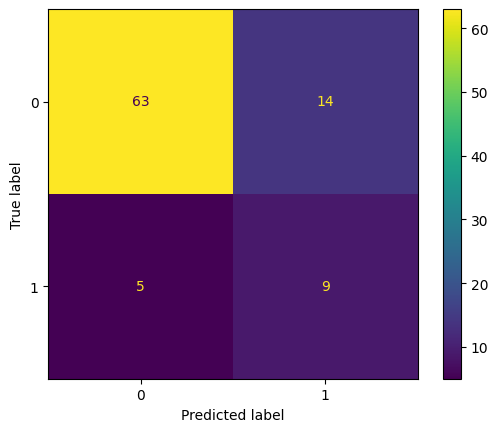

In [138]:
cm = confusion_matrix(y_test, y_pred, labels=best_rf_classifier_model.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=best_rf_classifier_model.classes_
)
disp.plot()
plt.show()

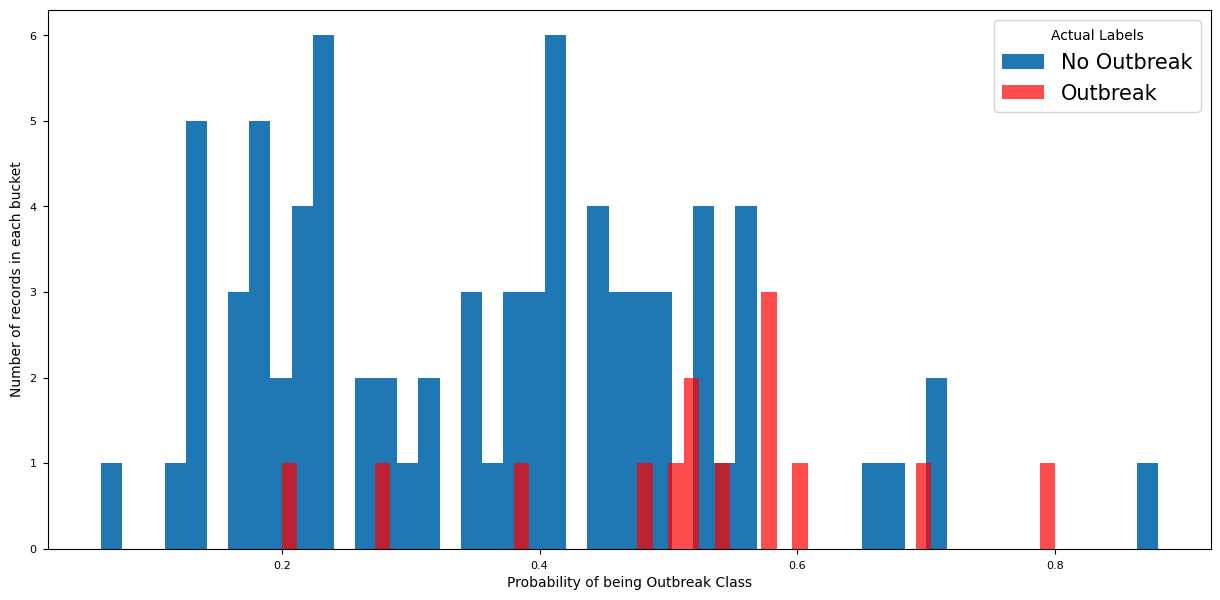

In [139]:
prediction = y_pred_proba[:, 1]  # prediction for outbreak
plt.figure(figsize=(15, 7))
plt.hist(prediction[y_test == 0], bins=50, label="No Outbreak")
plt.hist(prediction[y_test == 1], bins=50, label="Outbreak", alpha=0.7, color="r")
plt.xlabel("Probability of being Outbreak Class", fontsize=10)
plt.ylabel("Number of records in each bucket", fontsize=10)
plt.legend(fontsize=15, title="Actual Labels")
plt.tick_params(axis="both", labelsize=8, pad=5)
plt.show()

### 3. Identify features that best explains outbreak prediction

In [140]:
explainer = shap.Explainer(best_rf_classifier_model)
shap_values = explainer.shap_values(X_test)

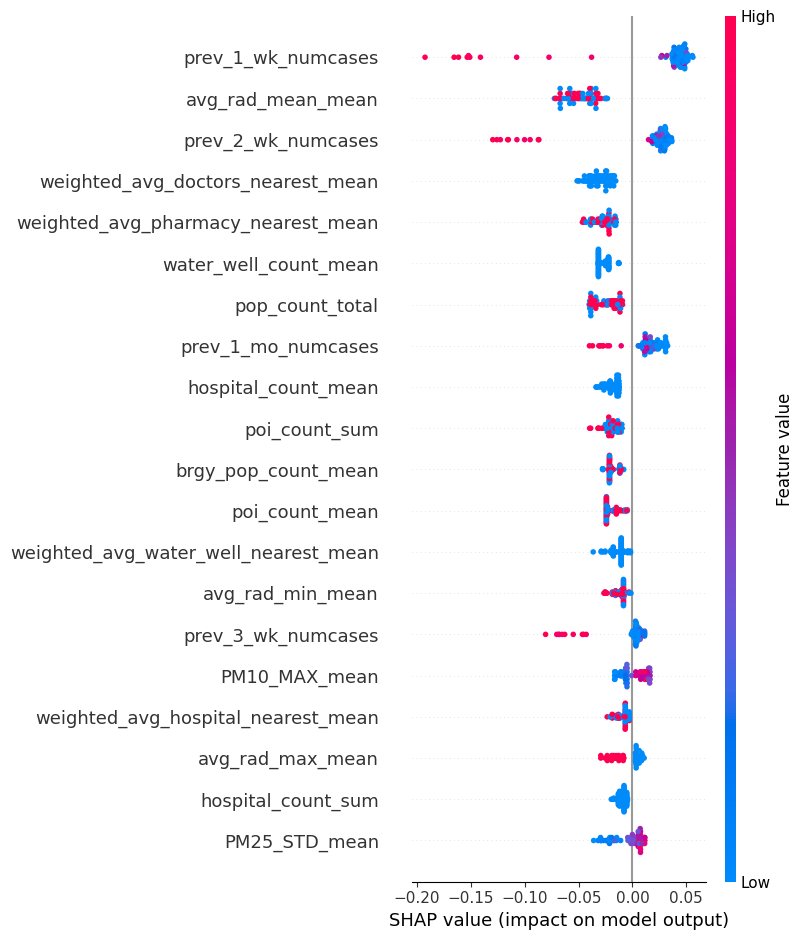

In [141]:
shap.summary_plot(shap_values[0], X_test)

## Analyzing outbreak predictions

In [142]:
# Join back the predictions to the features for analysis.
analyze_df = X_test.copy()
analyze_df["ADM3_PCODE"] = brgy_tests
analyze_df["Cases"] = numcases_test
analyze_df["actual_class"] = y_test
analyze_df["predicted_class"] = y_pred
analyze_df["predicted_proba_outbreak"] = y_pred_proba[:, 1]
analyze_df = analyze_df.reset_index()

### 1. Visualizing Actual vs. Predicted Outbreaks Periods 

In [143]:
actual_outbreaks_summary = create_outbreak_summary(analyze_df, "actual_class")
actual_outbreaks_summary["category"] = "actual"
predicted_outbreaks_summary = create_outbreak_summary(analyze_df, "predicted_class")
predicted_outbreaks_summary["category"] = "predicted"

In [144]:
outbreak_lengths_results = pd.concat(
    [actual_outbreaks_summary, predicted_outbreaks_summary]
)
outbreak_lengths_results

,outbreak_group,start_date,end_date,actual_length_weeks,category
0,1,2019-04-22,2019-05-06,3,actual
1,3,2019-08-19,2019-09-16,5,actual
2,5,2019-10-21,2019-11-04,3,actual
3,7,2019-11-25,2019-12-09,3,actual
0,1,2019-04-29,2019-04-29,1,predicted
1,3,2019-06-17,2019-06-24,2,predicted
2,5,2019-07-08,2019-07-08,1,predicted
3,7,2019-07-29,2019-07-29,1,predicted
4,9,2019-08-19,2019-09-09,4,predicted
5,11,2019-10-28,2019-11-04,2,predicted


In [145]:
# Set custom colors
class_colors = {"predicted": "#ee472f", "actual": "#53bed0"}

# Plot start and end outbreak points
fig = px.scatter(
    outbreak_lengths_results,
    x=["start_date", "end_date"],
    y="category",
    color="category",
    size="actual_length_weeks",
    labels={"x": "Date"},
    category_orders={"category": ["actual", "predicted"]},
    color_discrete_map=class_colors,
)

for i, row in outbreak_lengths_results.iterrows():
    fig.add_trace(
        go.Scatter(
            mode="lines",
            # layer="below",
            line=dict(
                color=class_colors[row["category"]],
                width=3,
                dash="solid",
            ),
            # connect the two markers
            x=[row["start_date"], row["end_date"]],
            y=[row["category"], row["category"]],
            showlegend=False,
        )
    )

# Update layout with title and axis titles
fig.update_layout(
    title="Dengue Outbreak Periods for Zamboanga City",
    xaxis_title="Date",
    yaxis_title="Category",
)
fig.show()

### 2. Visualize actual Number of Cases with Predicted label

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))


# Define colors for each class
class_colors = {0: "#53bed0", 1: "#ee472f"}

# Plot the bar plot
ax.bar(
    analyze_df["Date"],
    analyze_df["Cases"],
    alpha=0.5,
    label="Bar Plot",
    width=8,
    color=[class_colors[c] for c in analyze_df["predicted_class"]],
)

# Rotate x-axis labels
plt.xticks(rotation=30)

# Create legend handles and labels for bar plot
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, color=color) for color in class_colors.values()
]
legend_labels = list(class_colors.keys())

# Add legend for bar plot
ax.legend(legend_handles, legend_labels, fontsize="large", title="Predicted Outbreak")
# Add title and axis labels
ax.set_title("Dengue Outbreak Periods for Brgy. Tetuan in Zamboanga")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Cases")
plt.show()

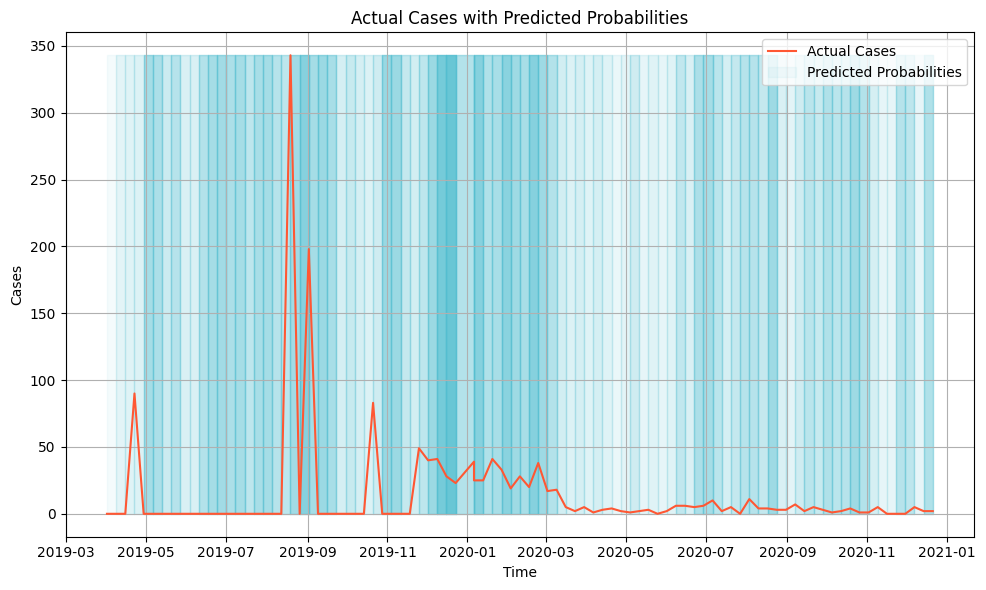

In [147]:
plt.figure(figsize=(10, 6))

# Plotting the line plot for actual cases with a different color
plt.plot(
    analyze_df["Date"],
    analyze_df["Cases"],
    color="#ff5733",  # Reddish color for better visibility
    label="Actual Cases",
)

# Define your own gradient color
gradient_color = "#53bed0"  # Blueish color for the gradient

# Define the number of points for the gradient
num_points = len(analyze_df)

# Create a custom colormap with the gradient color
colors = [(0, gradient_color), (1, gradient_color)]
cmap = LinearSegmentedColormap.from_list("custom_gradient", colors)

# Creating a background gradient for predicted probabilities
for i in range(len(analyze_df) - 1):
    start_date = analyze_df["Date"].iloc[i]
    end_date = analyze_df["Date"].iloc[i + 1]
    alpha = analyze_df["predicted_proba_outbreak"].iloc[
        i
    ]  # Use predicted probability as alpha
    plt.fill_between(
        analyze_df["Date"],  # x-values (dates)
        analyze_df["Cases"].min(),  # Bottom y-value (minimum of actual cases)
        analyze_df["Cases"].max(),  # Top y-value (maximum of actual cases)
        where=(
            (analyze_df["Date"] >= start_date) & (analyze_df["Date"] <= end_date)
        ),  # Condition for filling the area
        color=cmap(i / num_points),  # Use colormap to set gradient color
        alpha=alpha,  # Set alpha based on predicted probability
        label="Predicted Probabilities"
        if i == 0
        else None,  # Include legend only for the first fill_between
    )

# Add legend for the line plot and the gradient
plt.legend()

# Setting labels and title
plt.xlabel("Time")
plt.ylabel("Cases")
plt.title("Actual Cases with Predicted Probabilities")

# Displaying the plot
plt.grid(True)
plt.tight_layout()
plt.show()

### 3. Visualizing length of outbreaks + Predicted probability of an outbreak

In [ ]:
# Assuming sample_brgy contains the outbreak period data
class_colors = {"predicted": "#ee472f", "actual": "#53bed0"}


outbreak_actual = outbreak_lengths_results[
    outbreak_lengths_results["category"] == "actual"
]

num_years = analyze_df["Date"].dt.year.nunique()

fig = px.scatter(
    outbreak_actual,
    x=["start_date", "end_date"],
    y=outbreak_actual["start_date"].dt.year,
    color="category",
    size="actual_length_weeks",
    labels={"x": "Date"},
    category_orders={"category": ["actual"]},
    color_discrete_map=class_colors,
)

# Add dumbbell plot lines
for i, row in outbreak_actual.iterrows():
    fig.add_trace(
        go.Scatter(
            mode="lines",
            line=dict(
                color=outbreak_actual["category"].map(class_colors)[i],
                width=3,
                dash="solid",
            ),
            x=[row["start_date"], row["end_date"]],
            y=[row["start_date"].year, row["start_date"].year],
            showlegend=False,
        )
    )

# Multiply opacity based on predicted probability values
opacity = 0.1 + 0.7 * analyze_df["predicted_proba_outbreak"]

# Set constant y-coordinate for the bars
y_bar = []
for year in outbreak_actual["start_date"].dt.year.unique():
    y_bar.extend([year * 2] * len(analyze_df))


# Add probability of outbreak plot as a background
fig.add_trace(
    go.Bar(
        x=analyze_df["Date"],
        y=y_bar,
        marker=dict(
            color="pink", opacity=opacity, line=dict(color="rgba(0,0,0,0.2)", width=0.5)
        ),
        hoverinfo="text",
        text=[f"{prob:.2f}" for prob in analyze_df["predicted_proba_outbreak"]],
        showlegend=False,
    )
)

# Update layout with title and axis titles
fig.update_layout(
    title="Dengue Outbreak Periods for Zamboanga City with Probability of Outbreak",
    xaxis_title="Date",
    yaxis_title="Year",
    bargap=0,  # Remove gaps between bars
    barmode="overlay",  # Overlay the dumbbell plot
    yaxis=dict(
        tickvals=y_bar,  # Set y-tick values to the years
        ticktext=[
            f"{year}" for year in outbreak_actual["start_date"].dt.year.unique()
        ],  # Set y-tick labels to the year
    ),
)

fig.show()